In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import cm
from matplotlib.ticker import FuncFormatter
from sklearn.preprocessing import MinMaxScaler



In [2]:
# output directory
output_dir = "clustering_eval"
os.makedirs(output_dir, exist_ok=True)

# data
df = pd.read_csv("../model_eval/gridsearch_all_models_20250415-000937.csv")
dbscan_df = df[df["model"] == "DBScan"]
kmeans_gmm_df = df[df["model"].isin(["KMeans", "GMM"])]
df.tail(10)

,model,data_type,factor_analysis,eps,min_samples,calinski_harabasz,davies_bouldin,silhouette,n_clusters_found,cluster_entropy,n_components,covariance_type,max_iter,batch_size
170,KMeans,scores+survey_answers,False,NaN,NaN,1160.155487,3.087549,0.052764,5,2.273189,5.0,NaN,100.0,64.0
171,KMeans,scores+survey_answers,False,NaN,NaN,1173.619160,3.018823,0.061962,5,2.204791,5.0,NaN,100.0,128.0
172,KMeans,scores+survey_answers,False,NaN,NaN,946.652084,2.958734,0.048522,7,2.719274,7.0,NaN,100.0,64.0
173,KMeans,scores+survey_answers,False,NaN,NaN,936.274065,3.094819,0.046579,7,2.744630,7.0,NaN,100.0,128.0
174,KMeans,scores+survey_answers,False,NaN,NaN,779.308605,3.170182,0.036479,9,3.130874,9.0,NaN,100.0,64.0
175,KMeans,scores+survey_answers,False,NaN,NaN,879.610526,2.822648,0.045168,9,3.010486,9.0,NaN,100.0,128.0
176,KMeans,scores+survey_answers,False,NaN,NaN,616.678831,3.140438,0.029314,12,3.157014,12.0,NaN,100.0,64.0
177,KMeans,scores+survey_answers,False,NaN,NaN,716.092654,2.999759,0.039447,12,3.453247,12.0,NaN,100.0,128.0
178,KMeans,scores+survey_answers,False,NaN,NaN,587.194642,3.047284,0.036133,15,3.690927,15.0,NaN,100.0,64.0
179,KMeans,scores+survey_answers,False,NaN,NaN,615.440673,3.078885,0.035587,15,3.801784,15.0,NaN,100.0,128.0


# Impact of Factor Analysis on Silhouette Scores Across Models

/var/folders/m8/cmhpcfhj6qv_4p_mzqsd5p0m0000gn/T/ipykernel_54648/1045219103.py:17: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


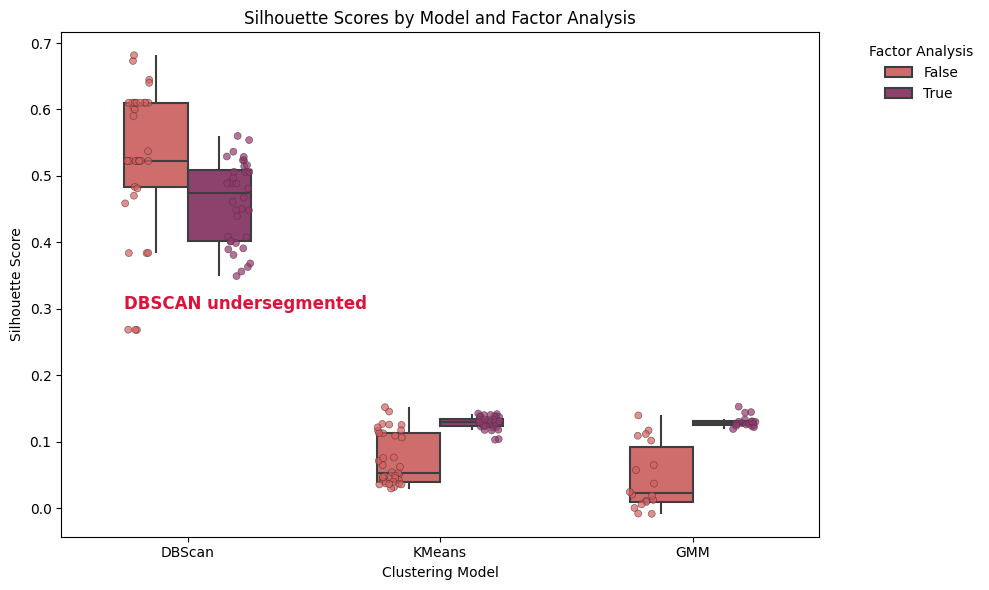

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
# remove nulls
df = df[df['silhouette'].notna()]
df['factor_analysis'] = df['factor_analysis']

model_order = ["DBScan", "KMeans", "GMM"]

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df, x="model", y="silhouette", hue="factor_analysis",
    order=model_order, palette="flare", showcaps=False, fliersize=0, width=0.5,
    linewidth=1.5
)

sns.stripplot(
    data=df, x="model", y="silhouette", hue="factor_analysis",
    dodge=True, jitter=True, order=model_order, palette="flare",
    marker='o', alpha=0.7, edgecolor='gray', linewidth=0.5
)

# adjust legends
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], title="Factor Analysis", bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)


# note
plt.text(-0.25, 0.3, "DBSCAN undersegmented", fontsize=12, color="crimson", weight="bold")

plt.title("Silhouette Scores by Model and Factor Analysis")
plt.xlabel("Clustering Model")
plt.ylabel("Silhouette Score")
plt.tight_layout()
plt.show()










# Cluster Size Distribution & Silhouette Score Comparison

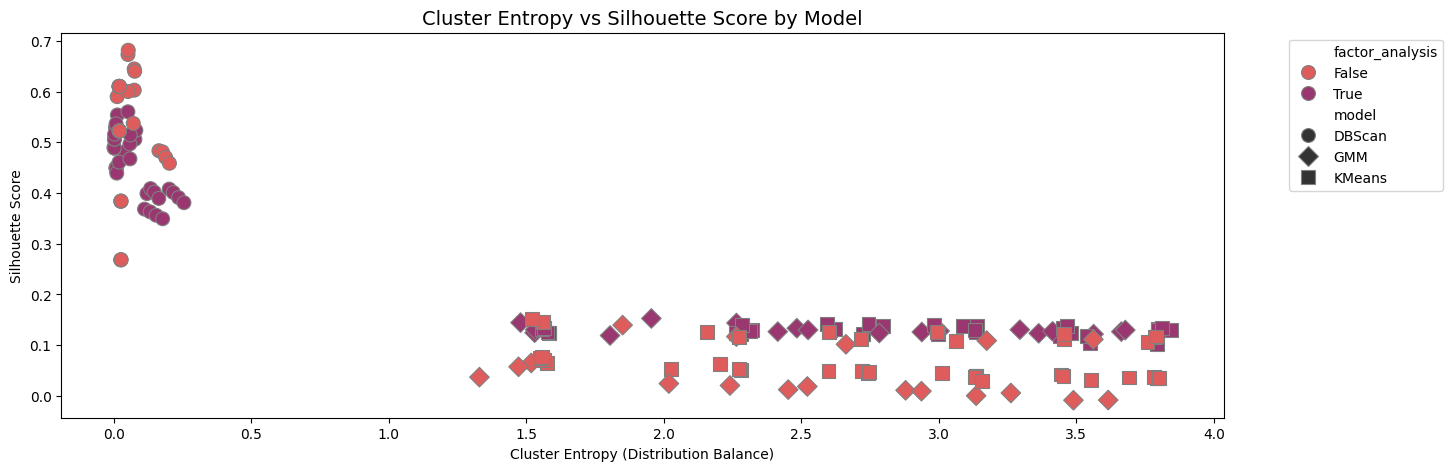

In [4]:

# filter nulls
df2 = df[df['cluster_entropy'].notna()].copy()

markers = {"DBScan": "o", "KMeans": "s", "GMM": "D"}
plt.figure(figsize=(15, 5))
sns.scatterplot(
    data=df2,
    x="cluster_entropy",
    y="silhouette",
    hue="factor_analysis",
    style="model",
    palette="flare",
    markers=markers,
    s=100,
    edgecolor='gray'
)


plt.title("Cluster Entropy vs Silhouette Score by Model", fontsize=14)
plt.xlabel("Cluster Entropy (Distribution Balance)")
plt.ylabel("Silhouette Score")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


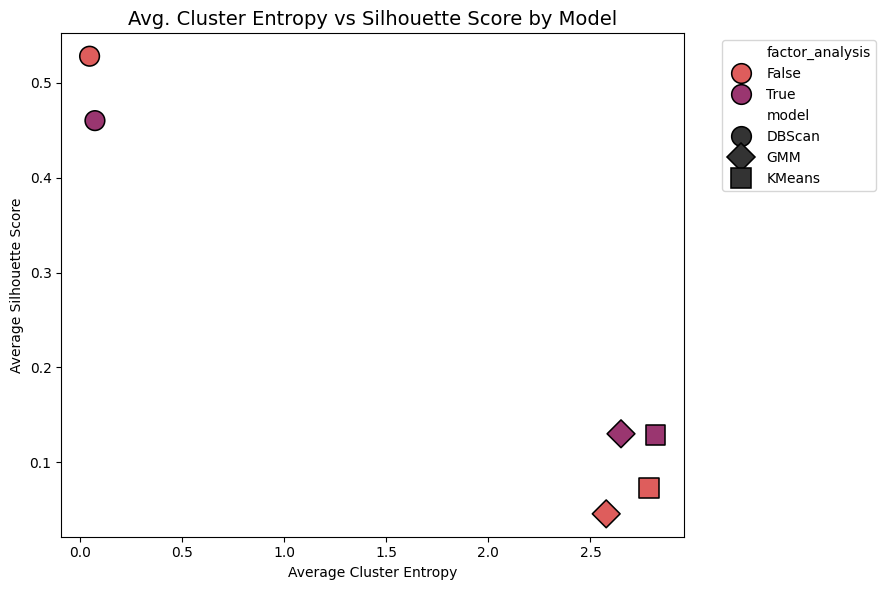

In [5]:
grouped_df = df2.groupby(['model', 'factor_analysis'], as_index=False)[['silhouette', 'cluster_entropy']].mean()

# plot mean silhouette vs entropy, one  per model X FA 
plt.figure(figsize=(9, 6))
sns.scatterplot(
    data=grouped_df,
    x="cluster_entropy",
    y="silhouette",
    hue="factor_analysis",
    style="model",
    palette="flare",
    markers=markers,
    s=200,
    edgecolor='black'
)

plt.title("Avg. Cluster Entropy vs Silhouette Score by Model", fontsize=14)
plt.xlabel("Average Cluster Entropy")
plt.ylabel("Average Silhouette Score")
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

/var/folders/m8/cmhpcfhj6qv_4p_mzqsd5p0m0000gn/T/ipykernel_54648/512008576.py:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Factor Analysis", loc='upper left', frameon=False)


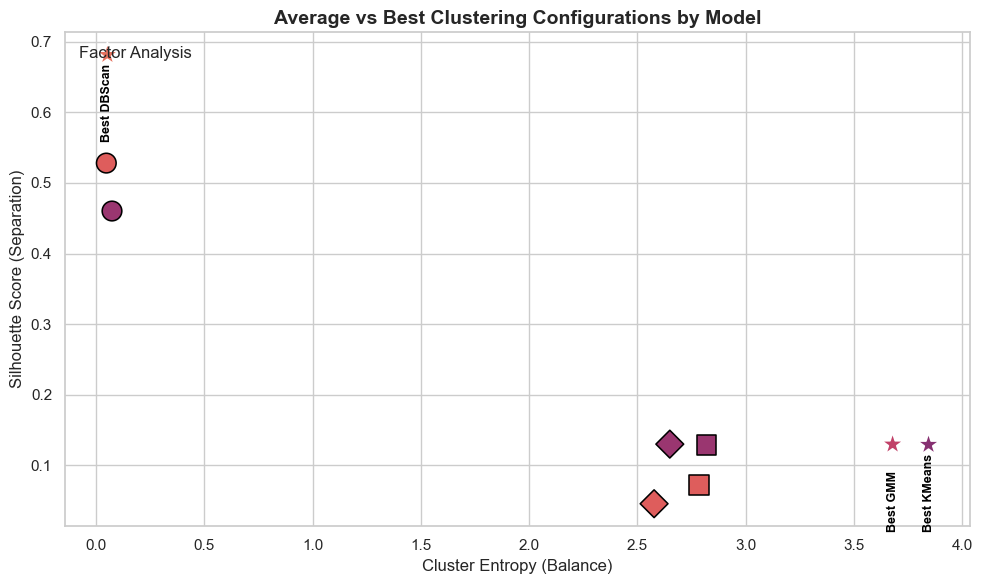

In [11]:
# mormalize silhouette and entropy & calculate a composite score
df2['silhouette_norm'] = (df2['silhouette'] - df2['silhouette'].min()) / (df2['silhouette'].max() - df2['silhouette'].min())
df2['entropy_norm'] = (df2['cluster_entropy'] - df2['cluster_entropy'].min()) / (df2['cluster_entropy'].max() - df2['cluster_entropy'].min())
df2['combined_score'] = df2['silhouette_norm'] + df2['entropy_norm']

# best model X FA  for each model
best_configs = df2.loc[df2.groupby('model')['combined_score'].idxmax()]

# averages for plotting
grouped_df = df2.groupby(['model', 'factor_analysis'], as_index=False)[['silhouette', 'cluster_entropy']].mean()

# max entropy for reference line
max_entropy = df2["cluster_entropy"].max()

plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

# average points
sns.scatterplot(
    data=grouped_df,
    x="cluster_entropy",
    y="silhouette",
    hue="factor_analysis",
    style="model",
    palette="flare",
    markers={"DBScan": "o", "KMeans": "s", "GMM": "D"},
    s=200,
    edgecolor='black',
    legend=False
)

# best configurations as stars
sns.scatterplot(
    data=best_configs,
    x="cluster_entropy",
    y="silhouette",
    hue="model",
    palette="flare",
    marker="*",
    s=300,
    legend=False
)

# best points
for _, row in best_configs.iterrows():
    plt.text(row['cluster_entropy'], row['silhouette'] - 0.12,
             f"Best {row['model']}", fontsize=9, weight="bold", color="black", ha='center', rotation = 'vertical')

plt.title("Average vs Best Clustering Configurations by Model", fontsize=14, weight="bold")
plt.xlabel("Cluster Entropy (Balance)", fontsize=12)
plt.ylabel("Silhouette Score (Separation)", fontsize=12)
plt.legend(title="Factor Analysis", loc='upper left', frameon=False)
plt.tight_layout()
plt.show()

In [ ]:
best_configs

,model,data_type,factor_analysis,eps,min_samples,calinski_harabasz,davies_bouldin,silhouette,n_clusters_found,cluster_entropy,n_components,covariance_type,max_iter,batch_size,silhouette_norm,entropy_norm,combined_score
101,DBScan,scores,False,2.0,20.0,1936.974790,5.810178,0.681622,2,0.052762,NaN,NaN,NaN,NaN,1.000000,0.013362,1.013362
77,GMM,scores+survey_answers,True,NaN,NaN,2219.312208,1.486692,0.129710,15,3.678000,15.0,tied,100.0,NaN,0.200473,0.956821,1.157294
58,KMeans,survey_answers,True,NaN,NaN,2061.758395,1.508891,0.129291,15,3.843917,15.0,NaN,100.0,64.0,0.199867,1.000000,1.199867


# CH/DB Scores vs Silhouette

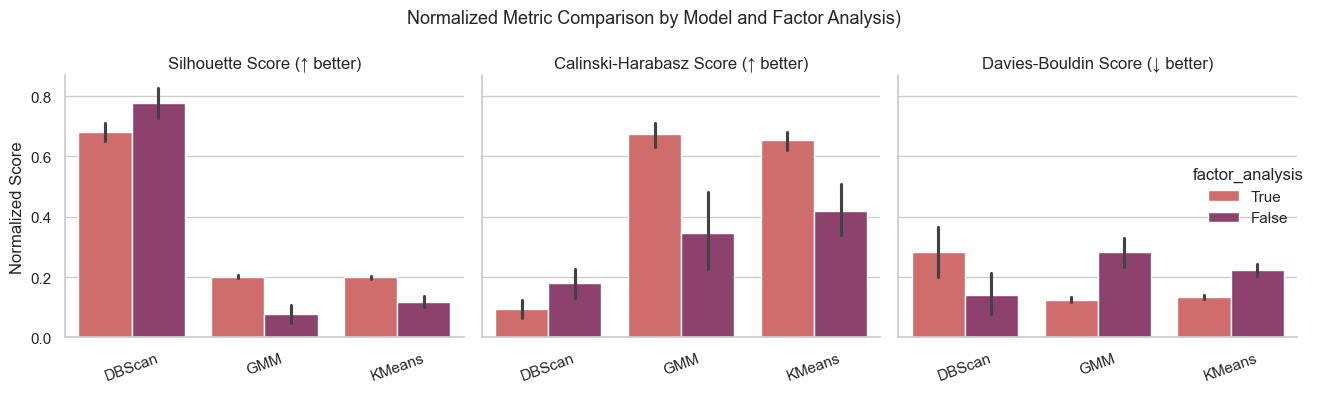

In [ ]:
# normalize 
scaler = MinMaxScaler()
df2[['silhouette_norm', 'calinski_norm', 'db_norm']] = scaler.fit_transform(
    df2[['silhouette', 'calinski_harabasz', 'davies_bouldin']]
)

# melt into long format
df_melted = df2.melt(
    id_vars=["model", "factor_analysis"],
    value_vars=["silhouette_norm", "calinski_norm", "db_norm"],
    var_name="metric",
    value_name="score"
)

# rename
df_melted['metric'] = df_melted['metric'].replace({
    'silhouette_norm': 'Silhouette Score (↑ better)',
    'calinski_norm': 'Calinski-Harabasz Score (↑ better)',
    'db_norm': 'Davies-Bouldin Score (↓ better)'
})

# plot
g = sns.catplot(
    data=df_melted,
    kind="bar",
    x="model",
    y="score",
    hue="factor_analysis",
    col="metric",
    palette="flare",
    height=4,
    aspect=1
)

# formatting
g.set_titles("{col_name}")
g.set_axis_labels("", "Normalized Score")
g.set_xticklabels(rotation=20)
g.figure.subplots_adjust(top=0.85)
g.figure.suptitle("Normalized Metric Comparison by Model and Factor Analysis)", fontsize=13)
plt.tight_layout()
plt.show()


In [ ]:
grouped = df_melted.groupby(['factor_analysis', 'metric','model']).mean()
grouped

score
factor_analysis metric                             model           
False           Calinski-Harabasz Score (↑ better) DBScan  0.180165
                                                   GMM     0.345345
                                                   KMeans  0.417567
                Davies-Bouldin Score (↓ better)    DBScan  0.140961
                                                   GMM     0.284891
                                                   KMeans  0.224566
                Silhouette Score (↑ better)        DBScan  0.777728
                                                   GMM     0.078628
                                                   KMeans  0.117648
True            Calinski-Harabasz Score (↑ better) DBScan  0.095300
                                                   GMM     0.673526
                                                   KMeans  0.653150
                Davies-Bouldin Score (↓ better)    DBScan  0.283153
                                                   GMM     0.125189
                                                   KMeans  0.133897
                Silhouette Score (↑ better)        DBScan  0.679330
                                                   GMM     0.200928
                                                   KMeans  0.198919

In [ ]:
grouped = df_melted.groupby(['factor_analysis', 'metric', 'model'])[['score']].mean().reset_index()

# summary sentences
### FOR JULIAN ###
summaries = []

for fa in grouped['factor_analysis'].unique():
    for metric in grouped['metric'].unique():
        subset = grouped[(grouped['factor_analysis'] == fa) & (grouped['metric'] == metric)]
        best_row = subset.loc[subset['score'].idxmax()]
        best_model = best_row['model']
        best_score = best_row['score']
        others = subset[subset['model'] != best_model]

        sentences = []
        for _, row in others.iterrows():
            avg = (best_score + row['score']) / 2
            pct_diff = round(abs(best_score - row['score']) / avg * 100, 1)
            sentences.append(f"{pct_diff}% better than {row['model']}")

        if sentences:
            statement = f"When looking at {metric.lower()} with factor analysis = {fa}, the highest performing model, {best_model}, scored {' and '.join(sentences)}."
            summaries.append(statement)

summary_text = "\n".join(summaries)
print(summary_text)

When looking at calinski-harabasz score (↑ better) with factor analysis = False, the highest performing model, KMeans, scored 79.4% better than DBScan and 18.9% better than GMM.
When looking at davies-bouldin score (↓ better) with factor analysis = False, the highest performing model, GMM, scored 67.6% better than DBScan and 23.7% better than KMeans.
When looking at silhouette score (↑ better) with factor analysis = False, the highest performing model, DBScan, scored 163.3% better than GMM and 147.4% better than KMeans.
When looking at calinski-harabasz score (↑ better) with factor analysis = True, the highest performing model, GMM, scored 150.4% better than DBScan and 3.1% better than KMeans.
When looking at davies-bouldin score (↓ better) with factor analysis = True, the highest performing model, DBScan, scored 77.4% better than GMM and 71.6% better than KMeans.
When looking at silhouette score (↑ better) with factor analysis = True, the highest performing model, DBScan, scored 108.7

In [ ]:
### for slides
table = pd.DataFrame({
    'n_estimators': [250],
    'min_samples_split': [2],
    'min_samples_leaf': [2],
    'max_leaf_nodes': [None],
    'max_features': ['sqrt'],
    'max_depth': [50],
    'bootstrap': [False]
})
table

,n_estimators,min_samples_split,min_samples_leaf,max_leaf_nodes,max_features,max_depth,bootstrap
0,250,2,2,None,sqrt,50,False


In [ ]:
# slides
best_params = {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': False}

row = pd.DataFrame([best_params])
row

,n_estimators,min_samples_split,min_samples_leaf,max_leaf_nodes,max_features,max_depth,bootstrap
0,250,2,2,None,sqrt,50,False


<function matplotlib.pyplot.show(close=None, block=None)>

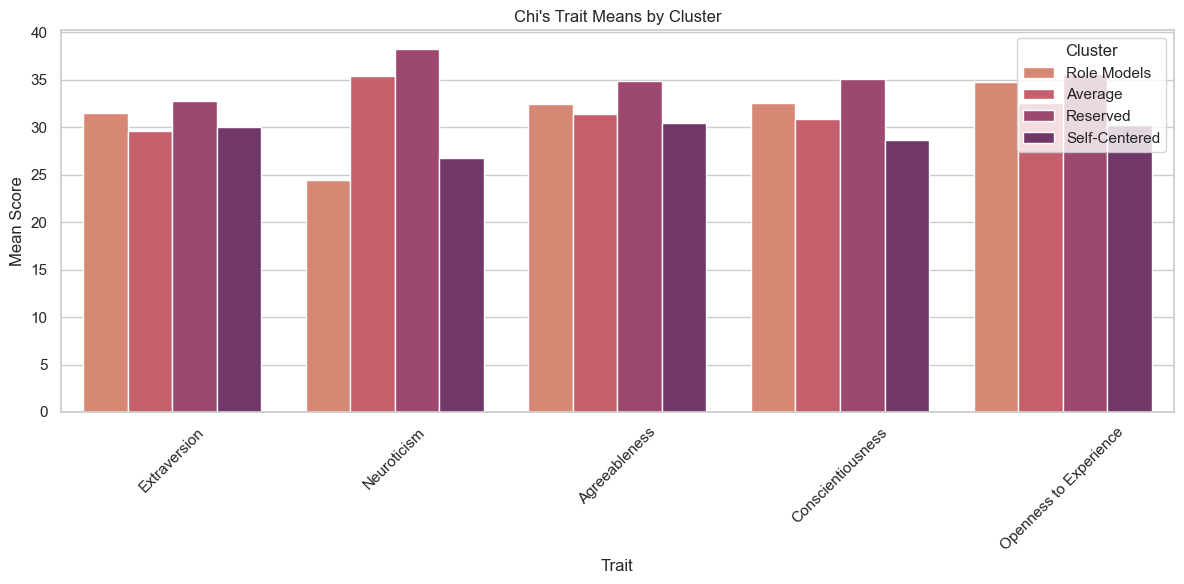

In [13]:
### slides
# Related Works recreation
data = {
    'Trait': ['Extraversion', 'Neuroticism', 'Agreeableness', 'Conscientiousness', 'Openness to Experience'],
    'Role Models_Mean': [31.52, 24.39, 32.41, 32.51, 34.8],
    'Role Models_SD': [3.2, 3.86, 3.15, 3.09, 2.86],
    'Average_Mean': [29.63, 35.41, 31.43, 30.89, 32.5],
    'Average_SD': [3.12, 3.34, 3.09, 3.22, 3.45],
    'Reserved_Mean': [32.76, 38.27, 34.86, 35.09, 35.6],
    'Reserved_SD': [3.87, 4.06, 3.36, 3.58, 3.5],
    'Self-Centered_Mean': [30.03, 26.8, 30.4, 28.67, 30.23],
    'Self-Centered_SD': [3.08, 3.53, 3.19, 3.07, 3.19]
}

df = pd.DataFrame(data)

long_df = pd.melt(
    df,
    id_vars='Trait',
    value_vars=[col for col in df.columns if 'Mean' in col],
    var_name='Cluster',
    value_name='Mean Score'
)

# fix cluster names
long_df['Cluster'] = long_df['Cluster'].str.replace('_Mean', '')

plt.figure(figsize=(12, 6))
sns.barplot(data=long_df, x='Trait', y='Mean Score', hue='Cluster', palette='flare')
plt.title("Chi's Trait Means by Cluster")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show

In [ ]:
long_df

,Trait,Cluster,Mean Score
0,Extraversion,Role Models,31.52
1,Neuroticism,Role Models,24.39
2,Agreeableness,Role Models,32.41
3,Conscientiousness,Role Models,32.51
4,Openness to Experience,Role Models,34.80
5,Extraversion,Average,29.63
6,Neuroticism,Average,35.41
7,Agreeableness,Average,31.43
8,Conscientiousness,Average,30.89
9,Openness to Experience,Average,32.50
